# **Machine Learning & Deep Learning: Kaggle 1**

*Master in Machine Learning for Health - 2023/2024*

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from google.colab import drive
drive.mount('/content/drive')

<ipython-input-1-ca518797a70c>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Mounted at /content/drive


In [2]:
path = '/MyDrive/Machine Learning/Kaggle Challenge 1'
df_test = pd.read_pickle('/content/drive/MyDrive/Machine Learning/Kaggle Challenge 1/data_v1_test.pickle')
df_train = pd.read_pickle('/content/drive/MyDrive/Machine Learning/Kaggle Challenge 1/data_v1_train.pickle')

df_train.head(2)


,projectID,startDate,endDate,totalCost,ecMaxContribution,frameworkProgramme,num_papers,num_patents,category,label,TFIDF
0,101030179,2021-08-31 22:00:00,2023-08-30 22:00:00,155364.48,155364.48,H2020,2,0,"[7, 22, 23]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,294212,2011-07-31 22:00:00,2015-07-30 22:00:00,100000.00,100000.00,FP7,0,0,"[5, 20, 22]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [3]:
print(df_train.shape)
print(df_test.shape)

(6983, 11)
(10476, 9)


Look for missing values.

In [4]:
nan_count_train = df_train.isna().sum()
nan_count_test = df_test.isna().sum()
print(nan_count_train)
print(nan_count_test)

projectID              0
startDate             14
endDate               14
totalCost              0
ecMaxContribution      0
frameworkProgramme     0
num_papers             0
num_patents            0
category               0
label                  0
TFIDF                  0
dtype: int64
projectID              0
startDate             23
endDate               23
totalCost              0
ecMaxContribution      0
frameworkProgramme     0
num_papers             0
num_patents            0
TFIDF                  0
dtype: int64


In [ ]:
rows_with_nan_in_train = df_train[df_train['startDate'].isna()]
print(rows_with_nan_in_train[['startDate', 'endDate']])

     startDate endDate
273        NaT     NaT
409        NaT     NaT
560        NaT     NaT
1596       NaT     NaT
1731       NaT     NaT
2254       NaT     NaT
3287       NaT     NaT
3431       NaT     NaT
5314       NaT     NaT
6109       NaT     NaT
6151       NaT     NaT
6383       NaT     NaT
6480       NaT     NaT
6794       NaT     NaT


In [ ]:
rows_with_nan_in_test = df_test[df_test['startDate'].isna()]
print(rows_with_nan_in_test[['startDate', 'endDate']])

      startDate endDate
7820        NaT     NaT
7837        NaT     NaT
7876        NaT     NaT
7949        NaT     NaT
8127        NaT     NaT
8429        NaT     NaT
8572        NaT     NaT
9037        NaT     NaT
9601        NaT     NaT
10536       NaT     NaT
11135       NaT     NaT
12051       NaT     NaT
12112       NaT     NaT
12730       NaT     NaT
13951       NaT     NaT
14314       NaT     NaT
14449       NaT     NaT
15040       NaT     NaT
15343       NaT     NaT
15546       NaT     NaT
15833       NaT     NaT
16963       NaT     NaT
17398       NaT     NaT


## **Data Prepocessing**

Steps to create the final training and test sets:

1. Solve NaN values in dates columns, for now dates are not used.
2. One-hot encode the Framework Programme and encode dates(not used).
3. Use the TFIDF features separately for each sample ($2000$ new features as first approach).
4. Discard the category column and use the labels as matrix Y.
5. Study class imabalance with matrix Y.

### 1. Encoding dates and framework column
Framework Programme es encoded using one-hot enconding and a new feature is added for every possible framework.

Dates are encoded using cyclical encoding for the month, day and hour. Only the year, month, day and hour are encoded, minutes and seconds are discarded.

For every cyclical encoding two new features are added, resulting in $7$ new features ($6$ for month, day and hour and $1$ for year).

In [5]:
# Encode FrameworkProgramme column
df_train_fe = pd.get_dummies(df_train, columns=['frameworkProgramme'])
df_test_fe = pd.get_dummies(df_test, columns=['frameworkProgramme'])
df_test_fe.head(2)

,projectID,startDate,endDate,totalCost,ecMaxContribution,num_papers,num_patents,TFIDF,frameworkProgramme_FP7,frameworkProgramme_H2020,frameworkProgramme_HORIZON
6983,101113193,2023-08-31 22:00:00,2026-08-30 22:00:00,2084871.88,2084871.25,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,1
6984,876600,2019-09-30 22:00:00,2020-02-28 23:00:00,71429.00,50000.00,0,0,"[0.0, 0.0, 0.07044837318360815, 0.0, 0.0, 0.0,...",0,1,0


In [6]:
# Define cyclical encoding function
def encode_cyclical(data, max_value):
   return (
       np.sin(2 * np.pi * data / max_value),
       np.cos(2 * np.pi * data / max_value)
   )

In [7]:
def encode_datetime(dataframe):
  df = dataframe.copy()

  # Encode datetime objects in train set
  df['startDate'] = pd.to_datetime(df['startDate'])
  df['endDate'] = pd.to_datetime(df['endDate'])

  # Extract components
  df['startYear'] = df['startDate'].dt.year
  df['startMonth'] = df['startDate'].dt.month
  df['startDay'] = df['startDate'].dt.day
  df['startHour'] = df['startDate'].dt.hour

  df['endYear'] = df['endDate'].dt.year
  df['endMonth'] = df['endDate'].dt.month
  df['endDay'] = df['endDate'].dt.day
  df['endHour'] = df['endDate'].dt.hour

  # Define the maximum values for each component
  max_month = 12
  max_day = 31
  max_hour = 23

  # Apply cyclical encoding
  df['startMonth_sin'], df['startMonth_cos'] = encode_cyclical(df['startMonth'], max_month)
  df['startDay_sin'], df['startDay_cos'] = encode_cyclical(df['startDay'], max_day)
  df['startHour_sin'], df['startHour_cos'] = encode_cyclical(df['startHour'], max_hour)

  df['endMonth_sin'], df['endMonth_cos'] = encode_cyclical(df['endMonth'], max_month)
  df['endDay_sin'], df['endDay_cos'] = encode_cyclical(df['endDay'], max_day)
  df['endHour_sin'], df['endHour_cos'] = encode_cyclical(df['endHour'], max_hour)

  # Drop original date-time columns and extracted components
  df_enc = df.drop(['startDate', 'endDate',
                'startMonth', 'startDay', 'startHour',
                'endMonth', 'endDay', 'endHour'], axis=1)

  return df_enc

In [10]:
# For now just drop dates
df_train_enc = df_train_fe.drop(['startDate', 'endDate'], axis=1)
df_test_enc = df_test_fe.drop(['startDate', 'endDate'], axis=1)

# # Encode dates in training set
# df_train_enc = encode_datetime(df_train_fe)
print(df_train_enc.columns)

# # Encode dates in test set
# df_test_enc = encode_datetime(df_test_fe)
print(df_test_enc.columns)


Index(['projectID', 'totalCost', 'ecMaxContribution', 'num_papers',
       'num_patents', 'category', 'label', 'TFIDF', 'frameworkProgramme_FP7',
       'frameworkProgramme_H2020', 'frameworkProgramme_HORIZON'],
      dtype='object')
Index(['projectID', 'totalCost', 'ecMaxContribution', 'num_papers',
       'num_patents', 'TFIDF', 'frameworkProgramme_FP7',
       'frameworkProgramme_H2020', 'frameworkProgramme_HORIZON'],
      dtype='object')


### 2. Preprocess TFIDF column

As a first approach vectors in TFIDF column are added as signle features to the dataframe and the TFIDF column is dropped.

In future preprocessing an autoencoder will be trained to reduce the TFIDF vector dimensionality to $4$ or $5$ features.

In [11]:
def create_new_columns(row):
    return pd.Series(row['TFIDF'])

In [12]:
# Preprocess training df
new_columns = df_train_enc.apply(create_new_columns, axis=1)
df_train_proc = pd.concat([df_train_enc, new_columns], axis=1)

# Preprocess test df
new_columns = df_test_enc.apply(create_new_columns, axis=1)
df_test_proc = pd.concat([df_test_enc, new_columns], axis=1)

# Check conversion
print(df_train_proc.shape)
print(df_test_proc.shape)

(6983, 2011)
(10476, 2009)


In [ ]:
# TODO: Future approach: train Sparse Autoencoder for dimensionality reduction of TFIDF to 4 or 5 features

### 3. Extract training and test matrices

Training and test matrices are extracted and converted into Numpy arrays ready to use in the different algorithms.

In [13]:
X_train = df_train_proc.drop(['category', 'label', 'TFIDF'], axis=1).to_numpy()
Y_train = np.array(df_train['label'].tolist())

X_test = df_test_proc.drop(['TFIDF'], axis=1).to_numpy()

# Check dimensions
print(X_train.shape, Y_train.shape)
print(X_test.shape)

(6983, 2008) (6983, 34)
(10476, 2008)


### 4. Analyze data imbalance

In a multilabel classification problem there are two approaches to analyze data imbalance:

1. Analyze number of samples per class: we can compute some interesting metrics such as the IRLbl, MeanIR, MaxIR and the CVIR. Metrics extrated from [this paper](https://www.sciencedirect.com/science/article/pii/S0031320321001527).
2. Analyze number of unique labels to find label relationships.

Text(0, 0.5, 'Number of samples')

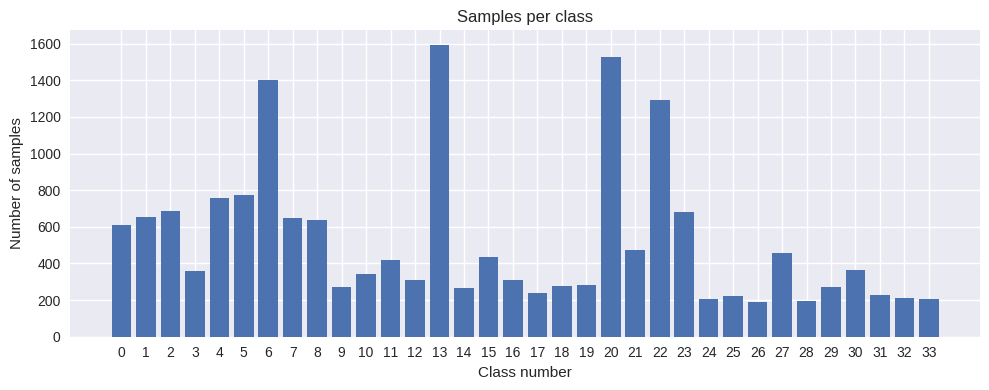

In [14]:
# Number of samples per class
samples_per_class = np.sum(Y_train, axis=0)

fig, ax = plt.subplots(figsize=(10, 4), layout='tight')
ax.bar(np.arange(0, 34), samples_per_class)
ax.set_xticks(np.arange(0,34))
ax.set_title('Samples per class')
ax.set_xlabel('Class number')
ax.set_ylabel('Number of samples')

In [15]:
# Compute metrics
IRLbl = np.max(samples_per_class) / samples_per_class
meanIR = np.mean(IRLbl)
maxIR = np.max(IRLbl)
CVIR = np.std(IRLbl)

print(f"Mean Imbalance Ratio: {meanIR}")
print(f"Max Imbalance Ratio: {maxIR}")
print(f"Coefficient of Variation of IR: {CVIR}")

Mean Imbalance Ratio: 4.441825812086713
Max Imbalance Ratio: 8.296875
Coefficient of Variation of IR: 2.2609665414828983


In [16]:
# Number of unique labels
label_combinations, count_list = np.unique(Y_train, axis=0, return_counts=True)

print(f"Number of different label combinations: {label_combinations.shape[0]}")
print(f"Ocurrences of most repeated label combination: {np.max(count_list)}")
print(f"Mean label combination repetitions: {np.mean(count_list):.3f}")
print(f"Standard deviation: {np.std(count_list):.3f}")

Number of different label combinations: 2688
Ocurrences of most repeated label combination: 231
Mean label combination repetitions: 2.598
Standard deviation: 8.013


## **Model Training**

As a general guide, models are trained after solving class imbalance either by subsampling (SMOTE) or by weighting the loss function.

Note that one-hot encoded data and TFIDF features are not normalized to avoid loosing information.

In [ ]:
# TODO: Solve class imbalance using over-sampling of minority classes (SMOTE)
  # Only resample samples with 1 label or use MLSMOTE algorithm (Zotero)

In [17]:
# TODO: cost function weighting depending on algorithm
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight('balanced', Y_train)
print(sample_weights.shape)
print(sample_weights)

(6983,)
[3.49004926e-07 1.11337995e-07 1.47774019e-07 ... 8.05856416e-08
 8.63300713e-08 1.03789427e-04]


One-hot encoded data and TFIDF vector are not normalized. Try datasets with more features each time with the same model to compare with baseline.

In [ ]:
# TODO

Bseline to compare with dummy classifier.

In [32]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train[:,:1], Y_train)

acc = accuracy_score(Y_train, dummy.predict(X_train[:,:8]))
print(f"Train accuracy: {acc*100:.3f}%")

Train accuracy: 3.308%


Model training and evaluation.

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

# Parameters
kfolds = 10
parameters = {'estimator__max_depth':np.arange(4, 12, 2)}

# Model CV
clf = MultiOutputClassifier(GradientBoostingClassifier(loss='exponential', n_estimators=100, max_depth=6))
# clf = GridSearchCV(model, parameters, cv=kfolds, scoring='neg_mean_squared_error',verbose=2, return_train_score=True)
clf.fit(X_train[:,:1], Y_train)

# Evaluation
acc = accuracy_score(Y_train, clf.predict(X_train[:,:1]))
print(f"Train accuracy: {acc*100:.3f}%")

Train accuracy: 4.253%


In [ ]:
print(f"Best params: {clf.best_params_}")
print(f"Train CV error: {clf.cv_results['mean_train_score']}")
print(f"Test CV error: {clf.cv_results['mean_test_score']}")

## **Predictions and submission file generation**